# How to stream LLM tokens from your graph

In this example we will stream tokens from the language model powering an agent. We will use a ReAct agent as an example. The main thing to bear in mind here is that using [async nodes](./async.ipynb) typically offers the best behavior for this, since we will be using the `astream_events` method.

This how-to guide closely follows the others in this directory, so we will call out differences with the **STREAMING** tag below (if you just want to search for those).

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        In this how-to, we will create our agent from scratch to be transparent (but verbose). You can accomplish similar functionality using the <code>create_react_agent(model, tools=tool)</code> (<a href="https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent">API doc</a>) constructor. This may be more appropriate if you are used to LangChain’s <a href="https://python.langchain.com/v0.2/docs/how_to/agent_executor/#concepts">AgentExecutor</a> class.
    </p>
</div>    

<div class="admonition warning">
    <p class="admonition-title">Note on Python < 3.11</p>
    <p>
        When using python 3.8, 3.9, or 3.10, please ensure you manually pass the RunnableConfig through to the llm when invoking it like so: <code>llm.ainvoke(..., config)</code>.
        The <a href="https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.base.Runnable.html#langchain_core.runnables.base.Runnable.astream_events">astream_events</a> method collects all events from your nested code using a streaming tracer passed as a callback. In 3.11 and above, this is automatically handled via <a href="https://docs.python.org/3/library/contextvars.html">contextvar</a>'s; prior to 3.11, <a href="https://docs.python.org/3/library/asyncio-task.html#asyncio.create_task">asyncio's tasks</a> lacked proper contextvar support, meaning that the callbacks will only propagate if you manually pass the config through. We do this in the <code>call_model</code> method below.
    </p>
</div>    

## Setup

First we need to install the packages required

In [26]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langsmith

Next, we need to set API keys for OpenAI (the LLM we will use).

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Set up the state

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a `State` object that it passes around to each node.
Each node then returns operations the graph uses to `update` that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the `State` object you use to construct the graph.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is "append-only".

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# Add messages essentially does this with more
# robust handling
# def add_messages(left: list, right: list):
#     return left + right


class State(TypedDict):
    messages: Annotated[list, add_messages]

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use create a placeholder search engine.
It is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.


In [4]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    return ["Cloudy with a chance of hail."]


tools = [search]

We can now wrap these tools in a simple [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode).
This is  a simple class that takes in a list of messages containing an [AIMessages with tool_calls](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.ai.AIMessage.html#langchain_core.messages.ai.AIMessage.tool_calls), runs the tools, and returns the output as [ToolMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.tool.ToolMessage.html#langchain_core.messages.tool.ToolMessage)s.


In [5]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## Set up the model

Now we need to load the chat model we want to use.
This should satisfy two criteria:

1. It should work with messages, since our state is primarily a list of messages (chat history).
2. It should work with tool calling, since we are using a prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)

**Note:** these model requirements are not requirements for using LangGraph - they are just requirements for this particular example.


In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo")


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for function calling, and then bind them to the model class.


In [7]:
model = model.bind_tools(tools)

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

**STREAMING**

We define each node as an async function.

<div class="admonition note">
    <p class="admonition-title">Manual Callback Propagation</p>
    <p>
        Note that in <code>call_model(state: State, config: RunnableConfig):</code> below, we a) accept the <a href="https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.config.RunnableConfig.html#langchain_core.runnables.config.RunnableConfig">RunnableConfig</a> in the node and b) pass this in as the second arg for <code>llm.ainvoke(..., config)</code>. This is optional for python 3.11 and later. If you ever have a problem where the LLM tokens are not streamed when using `astream_events` and you are using an older version of python, it's worth checking to ensure that the callbacks are manually propagated.</p>
</div>    

In [8]:
from typing import Literal

from langchain_core.runnables import RunnableConfig

from langgraph.graph import END, START, StateGraph


# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["__end__", "tools"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    else:
        return "tools"


# Define the function that calls the model
async def call_model(state: State, config: RunnableConfig):
    messages = state["messages"]
    # Note: Passing the config through explicitly is required for python < 3.11
    # Since context var support wasn't added before then: https://docs.python.org/3/library/asyncio-task.html#creating-tasks
    response = await model.ainvoke(messages, config)
    # We return a list, because this will get added to the existing list
    return {"messages": response}

## Define the graph

We can now put it all together and define the graph!

In [9]:
# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

workflow.add_edge("tools", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

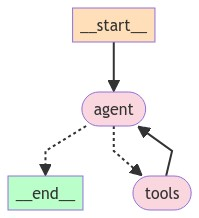

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Streaming LLM Tokens

You can access the LLM tokens as they are produced by each node. 
In this case only the "agent" node produces LLM tokens.
In order for this to work properly, you must be using an LLM that supports streaming as well as have set it when constructing the LLM (e.g. `ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)`)


In [11]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="what is the weather in sf")]
async for event in app.astream_events({"messages": inputs}, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

/Users/wfh/code/lc/langgraph/.venv/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


--
Starting tool: search with inputs: {'query': 'weather in San Francisco'}
Done tool: search
Tool output was: ['Cloudy with a chance of hail.']
--
The| weather| in| San| Francisco| is| currently| cloudy| with| a| chance| of| hail|.|